In [62]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from preprocess_ecg_data import load_ecg_data
from scipy.fft import fft, rfft, fftfreq, fftshift, dct
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.stats import zscore


ECG_LEN = 65536
ECG_WINDOW = 2000
F_SAMPLING = 128

F_MAX = F_SAMPLING/2
N_TOP_FREQ = 5
BPM_2_1HZ = 60

PATH = './ECGData.mat'

In [63]:
# Download heartpy library
# !python -m pip install heartpy

### __Task 0: Data preprocessing__

We are going to preprocess the data by taking the 162 samples of length 65536 and divide it in subsamples of length 2000, "windowing" the data. This will result in a dataframe that will have for each entry:
* A sample of length 200.
* The class of the subsample, wether is ARR (Arrhythmia), CHF (Congestive heart failure) or NSR (Normal sinus rhythm).
* Where sample was the subsample originally obtained.
* which n-th chunk of the original sample is the subsample (1-32).

### __Mapping of labels__: 
* #####    1:ARR (Arrhythmia)
* #####    2:CHF (Congestive heart failure)
* #####    3:NSR (Normal sinus rhythm)

In [64]:
ecg_data = load_ecg_data()

df_ecg_data = pd.DataFrame(ecg_data)
df_ecg_data 

,ecg_data,class,sampled_from,n_chunk
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


We are going to visualize one ECG from our dataset. First we are going to create a sample array. Since we know that the sample frequency was 128 hertz, we can create an array of length 2000 with 1/128 intervals.

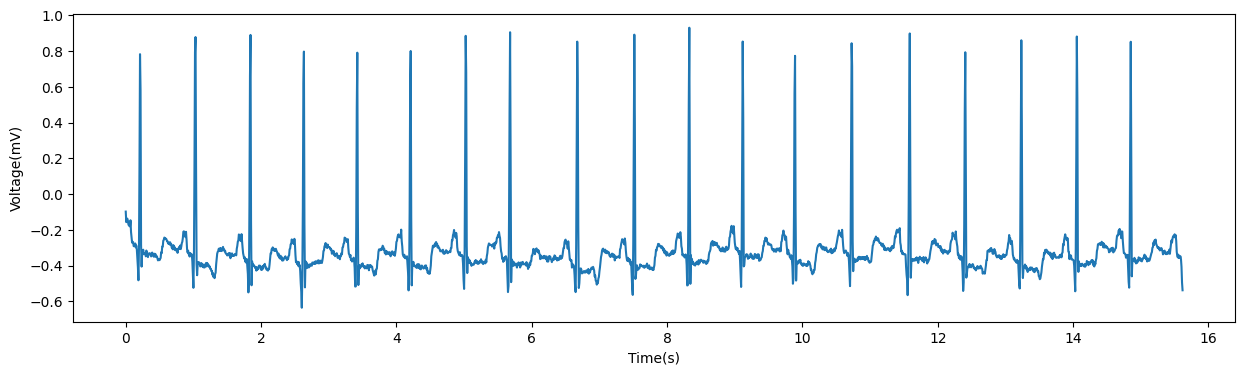

In [65]:
t_values = np.arange(0, ECG_WINDOW * 1/F_SAMPLING, 1/F_SAMPLING)
plt.figure(figsize=(15, 4))
plt.plot(t_values, df_ecg_data['ecg_data'][0])
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.show()

And there we have our ECG sample plotted. Now onto the tasks.

### __Task 1: Measuring the Heart rate from ECG signals.__

For this task take only ECG samples number 1 and 36 with the label NSR (normal sinus rhythm). For each of the two ECG examples divide the signal into windows of 2000 samples without overlapping. The remaining samples at the end of the file can be discarded.

In [66]:
# Taking the sample 1 and 36 from the NSR
df_ex1 = df_ecg_data[(df_ecg_data['class'] == 3) & ((df_ecg_data['sampled_from'] == 1) | (df_ecg_data['sampled_from'] == 36))]
df_ex1


,ecg_data,class,sampled_from,n_chunk
4032,"[-0.165, -0.155, -0.195, -0.205, -0.185, -0.15...",3,1,1
4033,"[-0.175, -0.175, -0.175, -0.175, -0.215, -0.18...",3,1,2
4034,"[2.235, 2.705, 2.525, 1.205, -0.255, -0.405, -...",3,1,3
4035,"[-0.095, -0.105, -0.115, -0.105, -0.095, -0.08...",3,1,4
4036,"[-0.125, -0.145, -0.165, -0.125, -0.065, -0.10...",3,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


The goal is to obtain the average heart rate for each of the windows considered using for this the analysis of the FFT (Fast Fourier Transform).
We can assume that each ECG sample is provided by two different persons. Therefore, plot an histogram for the average heart rate of the windows for each ECG separately.
Include an analysis of your method and comment your results.

In [67]:
ft = df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x)))
freq = df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1])))

# stack squeezes the dimensions of each entry in the pandas series. If we 
# have an array of N entries, each of one with an array of M values, this 
# operation will squeeze it to a matrix of N*M
np.stack(ft.values).shape

(64, 2000)

In [68]:
# we remain with the positive frequencies
halve_array = lambda x: x[int(len(x)/2):]

# apply the FFT to each of the 2000 windows
ft = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x))).values)
freq = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1]))).values)

freq.shape

(64, 2000)

Now, as we can see, the fft function of python gives us the whole range of frequencies (positives and negatives) normalized between $-1/2 \geq f \geq 1/2$. Since we only want the positive range of the frequencies, we are going to halve both the values of the fourier transform (`ft`) and the frequency index (`freq`) arrays.

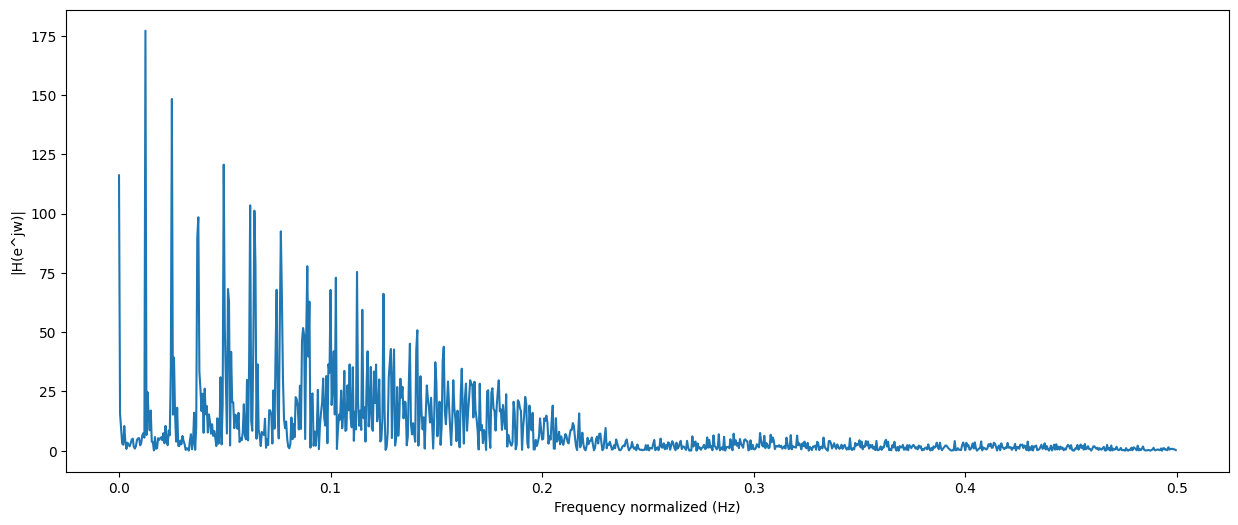

In [69]:
# we only get the positive frequencies
ft_positive = np.apply_along_axis(halve_array, axis=1, arr=ft)
freq_positive = np.apply_along_axis(halve_array, axis=1, arr=freq)

ft_sample = abs(np.array(ft_positive)[0].real)
freq = np.array(freq_positive)[0]

plt.figure(figsize=(15, 6))
plt.plot(freq, ft_sample)
plt.xlabel('Frequency normalized (Hz)')
plt.ylabel('|H(e^jw)|')
plt.show()

Now, we have only the positive range of values of our fourier transform.

We have another issue with this dataset, and it is the fact that, from the fourier transform, we only get the normalized frequencies, but our dataset was collected by sampling with a frequency of 128 Hz.

Following the Nyquist sampling theorem, a optimum frequency sample should follow the formula:

$$
f_s \geq 2 * f_{max}
$$

If we suppose that the frequency of sampling for this dataset follows this theorem, and $f_s=128$, then, the $f_{max}$ should be equal to 64. This means that, the higher frequency of the ECG, would suposedly be 64 Hz, and from that point, we could infer the rest of the frequencies from the normalized scale to the original one. Once we have done this, we convert the frequencies to BPM (by multiplying by 60, since 1hz -> 60BPM) and we would obtain our frequencies in the BPM domain.

In [70]:
# we order the frequencies depending on the highest value the fourier transform has
top_frequencies_idx = np.argsort(ft_sample)[::-1]
top_frequencies_idx[:N_TOP_FREQ]

array([ 25,  50,  99,   0, 124])

In [71]:
# we get the indices of the 
top_frequencies = freq[top_frequencies_idx[:N_TOP_FREQ]]
top_frequencies

array([0.0125, 0.025 , 0.0495, 0.    , 0.062 ])

In [72]:
frequencies_converted = (top_frequencies/freq[-1]*F_MAX)*BPM_2_1HZ
frequencies_converted

array([ 96.0960961 , 192.19219219, 380.54054054,   0.        ,
       476.63663664])

### __Task 3: Classification of ECG signals.__

* Let’s consider a balanced problem with the same number of examples per class. We will consider the first 30 ECG examples per class in this task.
* Divide the data into training and test sets considering the first 21 examples of each class for training and the remaining 9 examples per testing.
* Then remember that each ECG signal will be further divided into time windows with length 2000 samples without overlap. Each time window will be considered as a new example in the database.
* The objective of this task is to develop a system to automatically classify between the three types of ECG signals in the database. The measure to maximize is the accuracy.

In [73]:
ecg_data = load_ecg_data()
df_ecg_data = pd.DataFrame(ecg_data)

#### Feature extraction

We are going to extract some features from our dataset. In our case, we opted for using the FFT, the DCT over the FFT and some local and global features such as:
* Local Features: first derivatives and second derivatives
* Global Features: Avg distance between peaks or number of heartbeats

__Local Features extraction__: First derivatives and second derivatives

In [74]:
df_ecg_data['deriv1'] = df_ecg_data['ecg_data'].apply(lambda x: np.gradient(np.array(x)))
df_ecg_data['deriv2'] = df_ecg_data['deriv1'].apply(lambda x: np.gradient(np.array(x)))

__Global Features extraction__: Avg distance between peaks and number of heartbeats

In [75]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

stacked_data = np.stack(df_ecg_data['ecg_data'])

scaler = StandardScaler()
scaler.fit(stacked_data)
stacked_data_t = scaler.transform(stacked_data)

In [76]:
DISTANCE_BWTN_PEAKS = 40

def stretch_squeeze(x, factor=1):
    return np.sign(x) * np.exp(factor * np.abs(x))

def computing_rr(x):
    x_st_sq = stretch_squeeze(x)
    # compute cross correlation between ecg and the sine filter
    peaks_idx, _ = find_peaks(x_st_sq, distance=DISTANCE_BWTN_PEAKS, height=np.max(x_st_sq[:])*0.2)
    if peaks_idx.size == 0:
        x_st_sq = stretch_squeeze(-x)
        peaks_idx, _ = find_peaks(x_st_sq, distance=DISTANCE_BWTN_PEAKS, height=np.max(x_st_sq)*0.2)
    rr = np.diff(peaks_idx)

    # there are some samples that are quite faulty and we only compute one peak, for those cases
    # we return -1 and we replace the value with the mean of the class in order to not affect the
    # distribution of the data
    if rr.size == 0:
        return -1
    
    # compute the zscore in order to leave out the outliers that maybe product of an anomaly in the data
    rr_pd = pd.Series(rr)
    rr_corrected = rr_pd.copy()
    rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

    rr = np.array(rr_corrected)
    return rr

def avg_d_between_peaks(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    else:
        return np.mean(rr)
    
def std_d_between_peaks(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    else:
        return np.std(rr)

def compute_bpm(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    beat_period = np.mean(rr)/F_SAMPLING
    bpm = BPM_2_1HZ/beat_period
    return bpm

def compute_std_bpm(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    beat_period = rr/F_SAMPLING
    std_bpm = np.std(BPM_2_1HZ/beat_period)
    return std_bpm

def compute_max_bpm(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    beat_period = rr/F_SAMPLING
    std_bpm = np.max(BPM_2_1HZ/beat_period)
    return std_bpm

def compute_min_bpm(x):
    rr = computing_rr(x)
    rr_pd = pd.Series(rr)
    if rr_pd[rr_pd == -1].any():
        return np.nan
    beat_period = rr/F_SAMPLING
    std_bpm = np.min(BPM_2_1HZ/beat_period)
    return std_bpm

avg_d = np.apply_along_axis(avg_d_between_peaks, 1, stacked_data_t)
std_d = np.apply_along_axis(std_d_between_peaks, 1, stacked_data_t)
avg_bpm = np.apply_along_axis(compute_bpm, 1, stacked_data_t)
std_bpm = np.apply_along_axis(compute_std_bpm, 1, stacked_data_t)
max_bpm = np.apply_along_axis(compute_max_bpm, 1, stacked_data_t)
min_bpm = np.apply_along_axis(compute_min_bpm, 1, stacked_data_t)

df_ecg_data['avg_d_peaks'] = avg_d
df_ecg_data['std_d_peaks'] = std_d
df_ecg_data['avg_bpm'] = avg_bpm
df_ecg_data['std_bpm'] = std_bpm
df_ecg_data['max_bpm'] = max_bpm
df_ecg_data['min_bpm'] = min_bpm

In [77]:
df_ecg_data[df_ecg_data['avg_bpm'].isna()]

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
284,"[-1.0662847235264512, -1.0309784560564395, -1....",1,9,29,"[0.035306267470011754, 0.014066313509724204, -...","[-0.02123995396028755, -0.021985976017364184, ...",NaN,NaN,NaN,NaN,NaN,NaN
615,"[-0.35306386911786447, -0.3534806814825913, -0...",1,20,8,"[-0.00041681236472684846, 0.009831688078735107...","[0.010248500443461955, -0.01052156999218841, -...",NaN,NaN,NaN,NaN,NaN,NaN
689,"[-0.06535958358140768, -0.020601499800116285, ...",1,22,18,"[0.0447580837812914, 0.02524105334887101, 0.01...","[-0.019517030432420385, -0.01389549396888979, ...",NaN,NaN,NaN,NaN,NaN,NaN
698,"[0.015763687778235974, 0.004570186342316302, -...",1,22,27,"[-0.011193501435919672, -0.026332662590596398,...","[-0.015139161154676726, -0.007598680044177543,...",NaN,NaN,NaN,NaN,NaN,NaN
700,"[-0.20523783375186522, -0.21692920708203706, -...",1,22,29,"[-0.01169137333017184, -0.0012903085596754627,...","[0.010401064770496377, 0.003754522633824371, 0...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4003,"[-0.8385836676884582, -0.8618173636519676, -0....",2,30,4,"[-0.023233695963509438, 0.006395170470559042, ...","[0.02962886643406848, 0.010756855468702364, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4004,"[-0.2195897445696414, 0.6412007206669135, 1.07...",2,30,5,"[0.8607904652365549, 0.6483540194648197, -0.14...","[-0.21243644577173515, -0.5045516737018101, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4493,"[-0.275, -0.265, -0.235, -0.225, -0.225, -0.22...",3,15,14,"[0.010000000000000009, 0.020000000000000018, 0...","[0.010000000000000009, 0.0049999999999999975, ...",NaN,NaN,NaN,NaN,NaN,NaN
4494,"[-0.345, -0.355, -0.355, -0.345, -0.345, -0.33...",3,15,15,"[-0.010000000000000009, -0.0050000000000000044...","[0.0050000000000000044, 0.007500000000000007, ...",NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
bpm_means = df_ecg_data.groupby('class')['avg_bpm'].mean()
bpm_std_means = df_ecg_data.groupby('class')['std_bpm'].mean()
bpm_max_means = df_ecg_data.groupby('class')['max_bpm'].mean()
bpm_min_means = df_ecg_data.groupby('class')['min_bpm'].mean()
avd_d_means = df_ecg_data.groupby('class')['avg_d_peaks'].mean()
std_d_means = df_ecg_data.groupby('class')['std_d_peaks'].mean()

df_ecg_data['avg_bpm'] = df_ecg_data.apply(lambda row: bpm_means[row['class']] if pd.isna(row['avg_bpm']) else row['avg_bpm'], axis=1)
df_ecg_data['std_bpm'] = df_ecg_data.apply(lambda row: bpm_std_means[row['class']] if pd.isna(row['std_bpm']) else row['std_bpm'], axis=1)
df_ecg_data['max_bpm'] = df_ecg_data.apply(lambda row: bpm_max_means[row['class']] if pd.isna(row['max_bpm']) else row['max_bpm'], axis=1)
df_ecg_data['min_bpm'] = df_ecg_data.apply(lambda row: bpm_min_means[row['class']] if pd.isna(row['min_bpm']) else row['min_bpm'], axis=1)
df_ecg_data['avg_d_peaks'] = df_ecg_data.apply(lambda row: avd_d_means[row['class']] if pd.isna(row['avg_d_peaks']) else row['avg_d_peaks'], axis=1)
df_ecg_data['std_d_peaks'] = df_ecg_data.apply(lambda row: std_d_means[row['class']] if pd.isna(row['std_d_peaks']) else row['std_d_peaks'], axis=1)
df_ecg_data

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1,"[-0.059023956255582904, -0.019979427765969324,...","[0.03904452848961358, 0.0344381041616524, 0.00...",103.944444,2.717683,73.885623,1.922435,77.575758,69.818182
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2,"[0.3256653646076933, 0.4678561896988175, 0.493...","[0.14219082509112418, 0.08400456235294218, -0....",103.631579,3.029861,74.108685,2.152329,77.575758,69.818182
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3,"[-0.009963154478223213, -0.006462586527347575,...","[0.003500567950875638, 0.004696099230614967, 0...",103.666667,2.494438,74.083601,1.779547,76.800000,71.111111
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4,"[-0.00043569007826288475, 0.011976453998027381...","[0.012412144076290266, 0.005613563976551134, -...",103.944444,3.170563,73.885623,2.232525,76.800000,69.818182
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5,"[0.00675547248289321, 0.0002321741644971398, -...","[-0.00652329831839607, -0.003785852940457468, ...",102.861111,2.623640,74.663786,1.895985,78.367347,71.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28,"[0.0, 0.0, 0.04000000000000001, 0.09, 0.23, 0....","[0.0, 0.020000000000000004, 0.045, 0.095, 0.11...",124.218750,7.472802,61.826415,3.692136,70.458716,54.857143
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29,"[-0.010000000000000002, 0.035, 0.085, 0.07, 0....","[0.045000000000000005, 0.0475, 0.0175, -0.0175...",98.275000,4.526243,78.148054,3.465110,81.702128,71.111111
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30,"[-0.020000000000000018, -0.0050000000000000044...","[0.015000000000000013, 0.012500000000000011, -...",102.578947,4.464076,74.869164,3.181183,80.842105,67.368421
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31,"[0.04, -0.02, 0.0049999999999999975, 0.03, -0....","[-0.06, -0.0175, 0.025, -0.0225, -0.0024999999...",100.263158,4.375074,76.598425,3.319600,82.580645,70.458716


__FFT and DCT__

In [79]:
df_ecg_data['dct_1coef'] = df_ecg_data['ecg_data'].apply(lambda x: dct(rfft(20*np.log(np.abs(x)), n=2, norm='ortho').real)[0])
df_ecg_data['rfft'] = df_ecg_data['ecg_data'].apply(lambda x: fftshift(rfft(x).real))
df_ecg_data['dct'] = df_ecg_data['ecg_data'].apply(lambda x: dct(rfft(20*np.log(np.abs(x)), n=2, norm='ortho').real))
df_ecg_data['dct_orig'] = df_ecg_data['ecg_data'].apply(lambda x: dct(x, n=2, norm='ortho'))

#### Data Splitting for our classification 

In [80]:
range_class = range(1,4)
range_samples_per_class = range(1,31)
range_train_samples = range(1,22)
range_test_samples = range(22,31)

df_ex1 = df_ecg_data[df_ecg_data['sampled_from'].isin(range_samples_per_class)]
df_ex1_train = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_train_samples))]
df_ex1_test = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_test_samples))]

# dropping useless columns for classification
df_ex1_train = df_ex1_train.drop(columns=['sampled_from', 'n_chunk'])
df_ex1_test = df_ex1_test.drop(columns=['sampled_from', 'n_chunk'])

df_ex1_train

,ecg_data,class,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm,dct_1coef,rfft,dct,dct_orig
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,"[-0.059023956255582904, -0.019979427765969324,...","[0.03904452848961358, 0.0344381041616524, 0.00...",103.944444,2.717683,73.885623,1.922435,77.575758,69.818182,-131.479150,"[7.308770187223562, -2.975125420476547, 3.1658...","[-131.47915032557086, -74.0906432148001]","[-0.1801273625564558, 0.04173623972078081]"
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,"[0.3256653646076933, 0.4678561896988175, 0.493...","[0.14219082509112418, 0.08400456235294218, -0....",103.631579,3.029861,74.108685,2.152329,77.575758,69.818182,-59.644274,"[-0.8509693597644716, -0.43387649042429466, -0...","[-59.64427412981365, -151.3348547788289]","[-0.262447715816909, -0.23028018771168937]"
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,"[-0.009963154478223213, -0.006462586527347575,...","[0.003500567950875638, 0.004696099230614967, 0...",103.666667,2.494438,74.083601,1.779547,76.800000,71.111111,-46.949860,"[-2.1545647686565728, -0.6941227614785608, -4....","[-46.949859882378234, -32.29493369638703]","[-0.6237339628052204, 0.007045014093560752]"
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,"[-0.00043569007826288475, 0.011976453998027381...","[0.012412144076290266, 0.005613563976551134, -...",103.944444,3.170563,73.885623,2.232525,76.800000,69.818182,-54.230915,"[2.414067804874322, 2.9079420779818714, 2.7619...","[-54.23091537062379, -38.30161842043861]","[-0.5425176937760711, 0.0003080794088353834]"
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,"[0.00675547248289321, 0.0002321741644971398, -...","[-0.00652329831839607, -0.003785852940457468, ...",102.861111,2.623640,74.663786,1.895985,78.367347,71.111111,-63.901098,"[3.602600688934324, 0.5394721194316514, 6.1724...","[-63.9010983443081, -46.02995303831721]","[-0.4522336612372785, -0.0047768404027729115]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4699,"[0.215, 0.305, 0.225, -0.185, -0.705, -0.735, ...",3,"[0.09, 0.0050000000000000044, -0.245, -0.46499...","[-0.08499999999999999, -0.16749999999999998, -...",78.153846,1.349995,98.267717,1.698480,101.052632,96.000000,-86.952483,"[-0.502427086636333, -3.0746313572443134, 4.02...","[-86.9524825246418, -47.49774009498901]","[0.36769552621700474, -0.06363961030678927]"
4700,"[-0.105, -0.115, -0.105, -0.095, -0.085, -0.09...",3,"[-0.010000000000000009, 0.0, 0.010000000000000...","[0.010000000000000009, 0.010000000000000005, 0...",77.320000,0.881816,99.327470,1.132825,101.052632,97.215190,-127.493894,"[-0.9168012765538832, 1.453276592425455, 1.233...","[-127.49389420605894, -86.51292602475549]","[-0.15556349186104046, 0.0070710678118654805]"
4701,"[-0.025, -0.045, -0.055, -0.075, -0.085, -0.10...",3,"[-0.019999999999999997, -0.015, -0.015, -0.015...","[0.0049999999999999975, 0.0024999999999999988,...",75.307692,1.135756,101.981614,1.538768,105.205479,99.740260,-208.674534,"[-1.6304117583722908, 3.4163213294852843, 2.01...","[-208.67453415869554, -124.04371156847269]","[-0.04949747468305833, 0.014142135623730947]"
4702,"[-0.095, -0.085, -0.055, 0.095, 0.285, 0.375, ...",3,"[0.009999999999999995, 0.02, 0.09, 0.169999999...","[0.010000000000000005, 0.04, 0.075, 0.02500000...",78.269231,1.257522,98.122850,1.558433,99.740260,94.814815,-133.155470,"[-0.7008428839367877, -1.9405345228034683, -1....","[-133.15546958447854, -98.6041608996728]","[-0.12727922061357855, -0.007071067811865471]"


#### Classification

Now with our feature extraction completed, we are going to classify our samples. In order to do this we are going to use to approaches:

* __SVM__: We are going to use the SVC Support Vector Classifier from the `sklearn` library.
* __LSTM__: Since the data that we are using may have temporal dependencies, we think that a LSTM mixed with some features that we have extracted may work quite well classifying the samples. We will use `keras` for this approach.

In [87]:
X_train, y_train =  df_ex1_train.loc[:, df_ex1_train.columns!='class'], df_ex1_train['class']
X_test, y_test =  df_ex1_test.loc[:, df_ex1_test.columns!='class'], df_ex1_test['class']
X_train_svm =  X_train.loc[:, X_train.columns.difference(['deriv1', 'deriv2', 'rfft', 'dct', 'ecg_data', 'dct_orig'])]
X_test_svm =  X_test.loc[:, X_train.columns.difference(['deriv1', 'deriv2', 'rfft', 'dct', 'ecg_data', 'dct_orig'])]

In [88]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Constantes
C=15
KERNEL='rbf'

clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_svm,y_train)

y_train_pred = clf.predict(X_train_svm)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_svm)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.7822420634920635 | Test score: 0.5324074074074074


In [89]:
X_train_ecg_data = X_train['ecg_data'].values
X_train_ecg_data = np.stack(X_train_ecg_data)
X_test_ecg_data = X_test['ecg_data'].values
X_test_ecg_data = np.stack(X_test_ecg_data)

clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_ecg_data,y_train)

y_train_pred = clf.predict(X_train_ecg_data)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_ecg_data)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.9910714285714286 | Test score: 0.7337962962962963


In [90]:
train_ecg_data = X_train['ecg_data'].values
train_ecg_data = np.stack(train_ecg_data)
test_ecg_data = X_test['ecg_data'].values
test_ecg_data = np.stack(test_ecg_data)

train_dct = X_train['dct_orig'].values
train_dct = np.stack(train_dct)
test_dct = X_test['dct_orig'].values
test_dct = np.stack(test_dct)

X_train = np.concatenate([train_ecg_data, train_dct], axis=1)
X_test = np.concatenate([test_ecg_data, test_dct], axis=1)

clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train,y_train)

y_train_pred = clf.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.9910714285714286 | Test score: 0.7314814814814815


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM
from keras import Sequential
import math

X_train, y_train =  df_ex1_train.loc[:, df_ex1_train.columns!='class'], df_ex1_train['class']
X_test, y_test =  df_ex1_test.loc[:, df_ex1_test.columns!='class'], df_ex1_test['class']

X_train_ecg_data = X_train['ecg_data'].values
X_train_ecg_data = np.stack(X_train_ecg_data)
X_train_ecg_data

X_test_ecg_data = X_test['ecg_data'].values
X_test_ecg_data = np.stack(X_test_ecg_data)
X_test_ecg_data

# It is possible to change the variables: units of layers, function loss, optimizer, epochs, and batch size
LOSS='mean_squared_error'
OPTIMIZER='adam'
EPOCHS=100
BATCH=1

# Design the model
# Input: shape of the X_train_ecg_data
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_ecg_data.shape[1], X_train_ecg_data.shape[2])))

model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))

# Output: three possibles targets (1,2,3)
model.add(Dense(units=3))

# Compile the model
model.compile(loss=LOSS, optimizer=OPTIMIZER)

# Training the model
model.fit(X_train_ecg_data, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=2)

# Evaluate the model
trainScore = model.evaluate(X_train_ecg_data, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test_ecg_data, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# Evaluate the model with loss and accuracy
loss, accuracy = model.evaluate(X_test_ecg_data, y_test, verbose=0)

# Make a prediction on a single input example
y_test_pred = model.predict(X_test_ecg_data)
test_score = accuracy_score(y_test, y_test_pred)